In [51]:
from dynamic_pricing.db.db_utils import get_db_connection, load_order_data
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [52]:
conn = get_db_connection()

df: pd.DataFrame = load_order_data(conn,"nostimo")
print(df.info)

2024-03-26 15:03:28,434 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2024-03-26 15:03:28,434 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-26 15:03:28,738 INFO sqlalchemy.engine.Engine select current_schema()
2024-03-26 15:03:28,739 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-26 15:03:29,032 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2024-03-26 15:03:29,034 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-26 15:03:30,366 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-03-26 15:03:30,367 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [53]:
print(df.columns)
df.head()
df.fillna(0, inplace=True)

exclusion_categories = [
    "Desserts",
    "Soft Drinks",
    "Starters and Sharers",
    "Handmade Single Grills",
]

for category in exclusion_categories:
    df = df[~df["item_operational_name"].str.contains(category)]


Index(['order_id', 'deliveroo_order_id', 'deliveroo_order_number',
       'order_status', 'order_placed_timestamp', 'order_updated_timestamp',
       'order_prepare_for_timestamp', 'order_start_prepping_at_timestamp',
       'customer_id', 'first_name', 'contact_number', 'contact_access_code',
       'partner_id', 'partner_name', 'item_id', 'deliveroo_item_id',
       'item_name', 'item_operational_name', 'item_fractional_cost',
       'item_quantity', 'item_fractional_price', 'modifier_id',
       'deliveroo_modifier_id', 'modifier_name', 'modifier_operational_name',
       'modifier_quantity', 'modifier_fractional_price'],
      dtype='object')


/tmp/ipykernel_32503/1064325183.py:3: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Filter to keep only the items we are analyzing

In [54]:
pre_dp_df = df[
    (df["order_placed_timestamp"] >= "2023-06-26")
    & (df["order_placed_timestamp"] < "2023-7-17")
]
all_items_pre_dp_df = pre_dp_df.copy()
pre_dp_df = pre_dp_df[~pre_dp_df["item_operational_name"].str.contains("Wrap")]

pre_dp_df.info()


post_dp_df = df[
    (df["order_placed_timestamp"] >= "2023-7-17")
    & (df["order_placed_timestamp"] < "2023-8-07")
]
all_items_post_dp_df = post_dp_df.copy()

post_dp_df = post_dp_df[~post_dp_df["item_operational_name"].str.contains("Wrap")]

post_dp_df.info()

interval = 30

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 6 to 235
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   order_id                           50 non-null     int64         
 1   deliveroo_order_id                 50 non-null     object        
 2   deliveroo_order_number             50 non-null     int64         
 3   order_status                       50 non-null     object        
 4   order_placed_timestamp             50 non-null     datetime64[ns]
 5   order_updated_timestamp            50 non-null     datetime64[ns]
 6   order_prepare_for_timestamp        50 non-null     datetime64[ns]
 7   order_start_prepping_at_timestamp  50 non-null     datetime64[ns]
 8   customer_id                        50 non-null     int64         
 9   first_name                         50 non-null     int64         
 10  contact_number                     50 non-nu

In [55]:
def split_weekdays_and_weekends(df:pd.DataFrame,time_col:str):
    weekdays_df = df[
        df[time_col].dt.dayofweek < 5
    ]
    weekend_df = df[df[time_col].dt.dayofweek >= 5]
    return weekdays_df, weekend_df




pre_dp_df_weekdays, pre_dp_df_weekends = split_weekdays_and_weekends(
    pre_dp_df, "order_placed_timestamp"
)
post_dp_df_weekdays, post_dp_df_weekends = split_weekdays_and_weekends(
    post_dp_df, "order_placed_timestamp"
)

analysis

/tmp/ipykernel_32503/3244536412.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



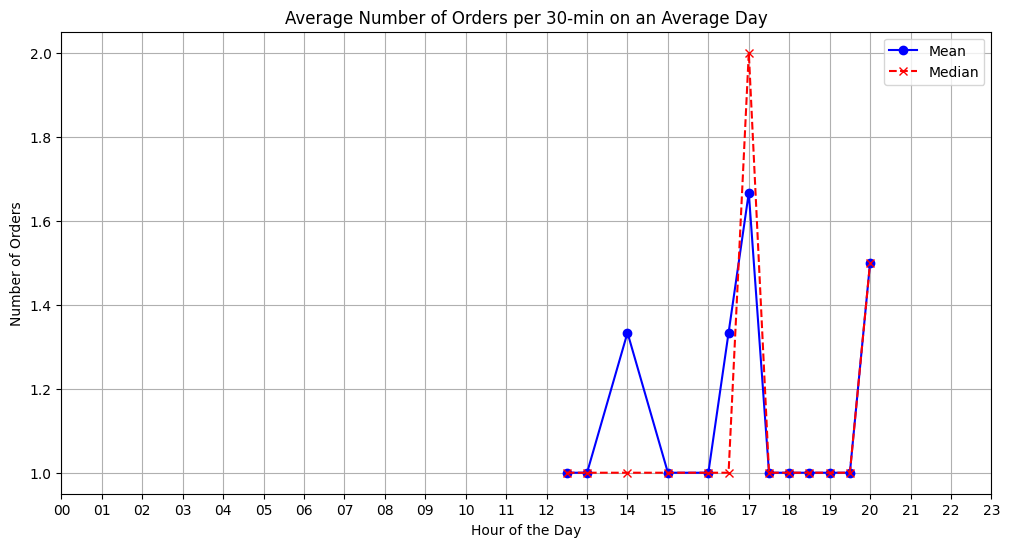

/tmp/ipykernel_32503/3244536412.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



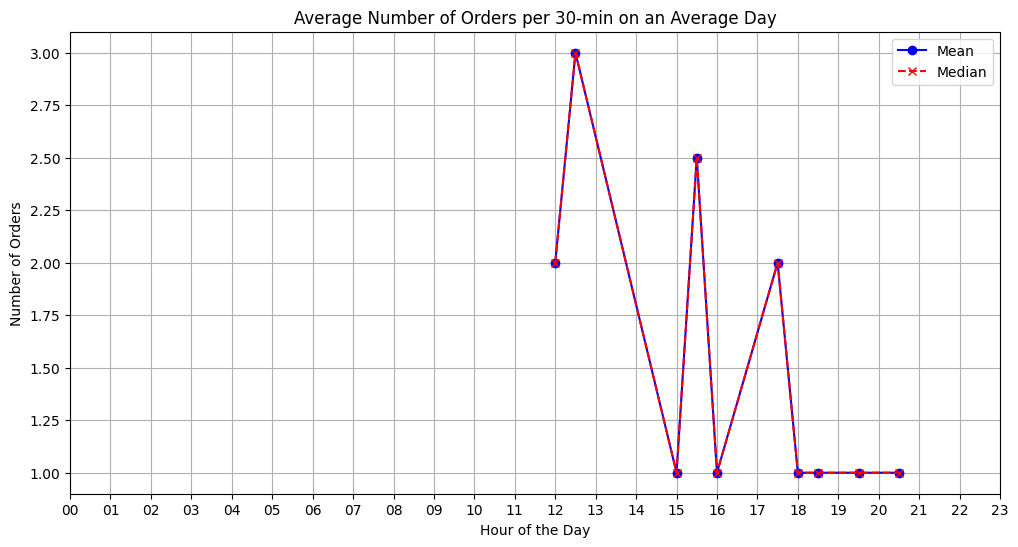

/tmp/ipykernel_32503/3244536412.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



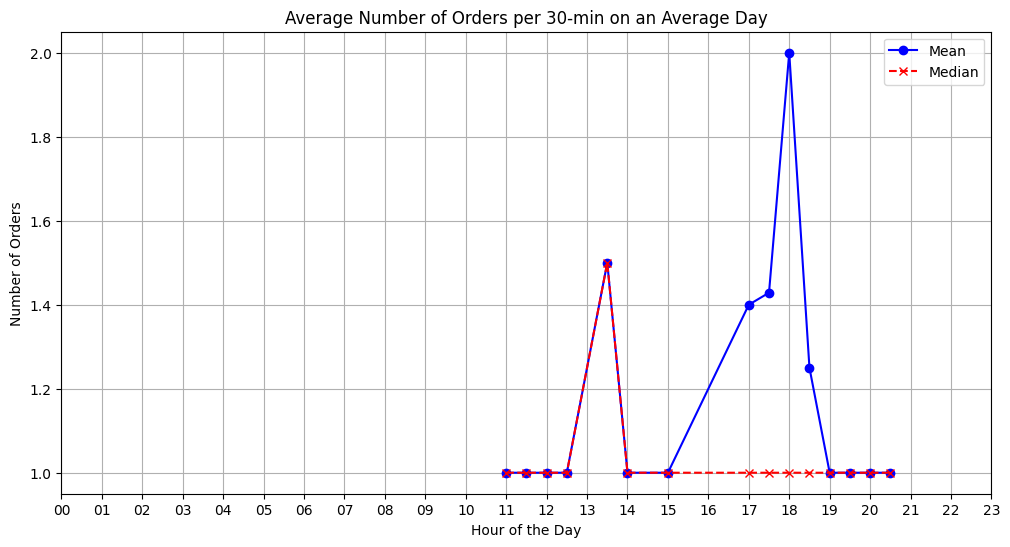

/tmp/ipykernel_32503/3244536412.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



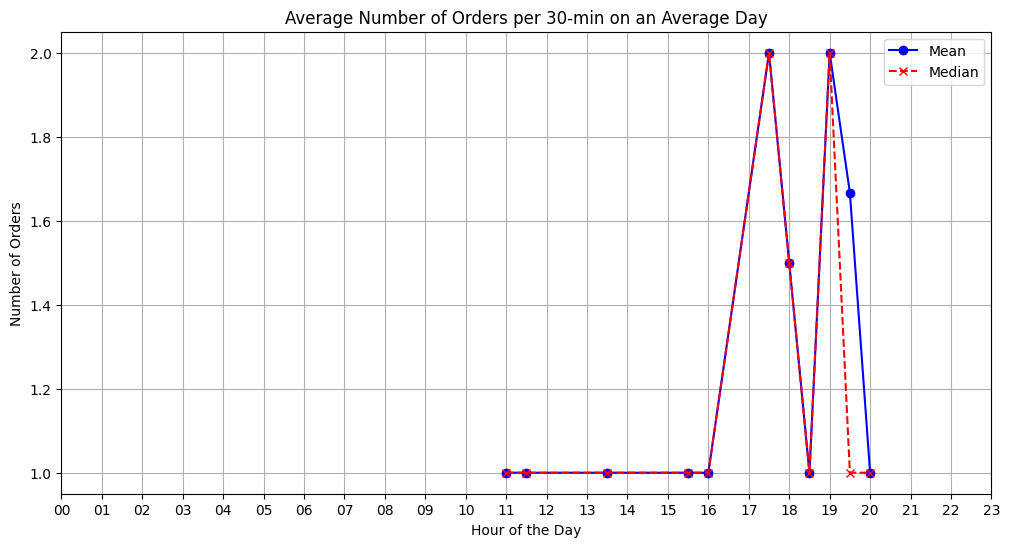

In [56]:
def plot_average_orders_per_interval(df: pd.DataFrame, interval: int):
    order_timestamp = "order_placed_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    # Create a new column for the interval index
    df["interval_index"] = (
        df[order_timestamp].dt.hour * 60
        + df[order_timestamp].dt.minute
    ) // interval

    # Calculate the actual average number of orders for each interval on an average day
    actual_average_orders = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])
        .size()
        .groupby("interval_index")
        .mean()
    )

    # Calculate the median number of orders for each interval on an average day
    median_orders = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])
        .size()
        .groupby("interval_index")
        .median()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plotting both mean and median
    plt.figure(figsize=(12, 6))
    plt.plot(
        actual_average_orders, marker="o", linestyle="-", color="blue", markersize=6, label="Mean"
    )
    plt.plot(
        median_orders, marker="x", linestyle="--", color="red", markersize=6, label="Median"
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Number of Orders")
    plt.title(f"Average Number of Orders per {interval}-min on an Average Day")
    plt.xticks(range(0, num_intervals, 60 // interval), x_labels)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_average_orders_per_interval(pre_dp_df_weekdays, interval=interval)
plot_average_orders_per_interval(pre_dp_df_weekends, interval=interval)

plot_average_orders_per_interval(post_dp_df_weekdays, interval=interval)
plot_average_orders_per_interval(post_dp_df_weekends, interval=interval)

    order_id  item_quantity  item_fractional_price  modifier_fractional_price  \
6          4              1                   1650                          0   
12        12              1                   1700                          0   
19        18              2                   1700                          0   
20        18              1                   1650                          0   
27        24              1                   1890                          0   

    modifier_quantity order_placed_timestamp  order_value  revenue  
6                   0    2023-06-26 17:42:24         16.5     16.5  
12                  0    2023-06-26 20:16:17         17.0     17.0  
19                  0    2023-06-27 16:34:37         34.0     50.5  
20                  0    2023-06-27 16:34:37         16.5     50.5  
27                  0    2023-06-28 14:19:35         18.9     18.9  


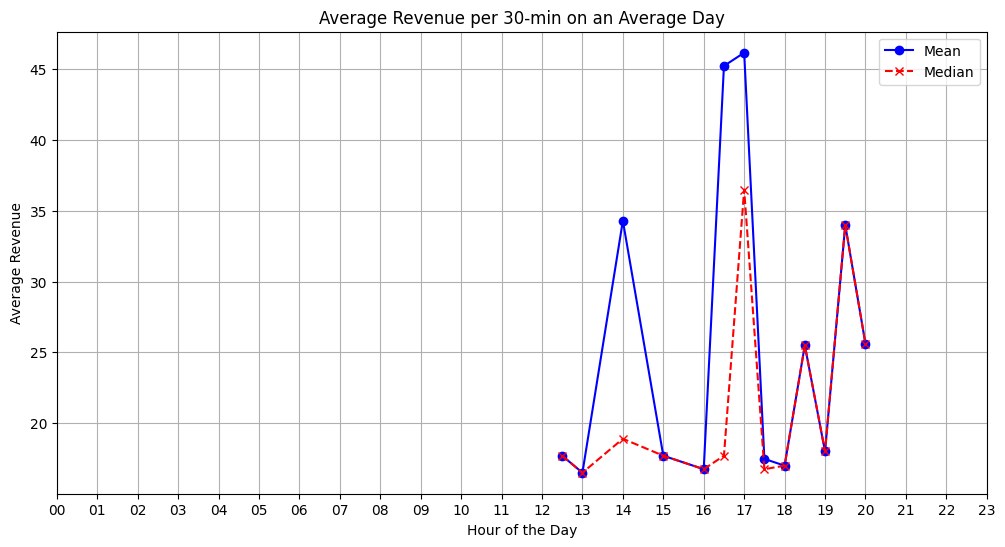

    order_id  item_quantity  item_fractional_price  modifier_fractional_price  \
48        42              1                   1650                          0   
49        44              1                   1700                          0   
53        48              1                   1700                          0   
55        50              1                   1650                          0   
56        52              1                   1700                          0   

    modifier_quantity order_placed_timestamp  order_value  revenue  
48                  0    2023-07-01 12:03:05         16.5     16.5  
49                  0    2023-07-01 12:06:25         17.0     17.0  
53                  0    2023-07-01 12:54:16         17.0     17.0  
55                  0    2023-07-01 12:54:41         16.5     16.5  
56                  0    2023-07-01 12:57:12         17.0     17.0  


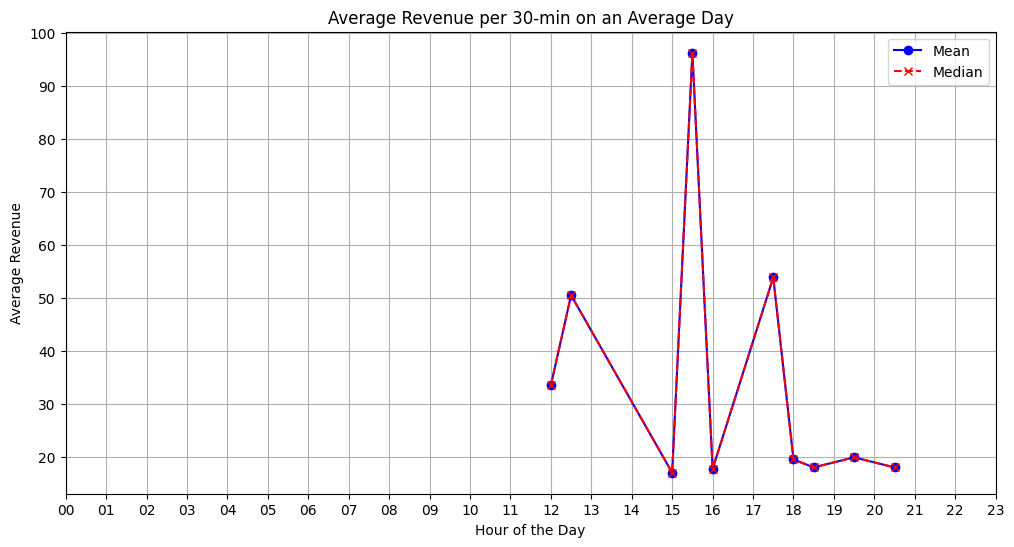

     order_id  item_quantity  item_fractional_price  \
251       218              1                   1770   
257       224              1                   1650   
258       226              1                   1650   
259       228              1                   1800   
265       232              1                   1800   

     modifier_fractional_price  modifier_quantity order_placed_timestamp  \
251                          0                  0    2023-07-18 15:11:35   
257                          0                  0    2023-07-19 11:27:48   
258                          0                  0    2023-07-19 11:37:55   
259                          0                  0    2023-07-19 17:42:57   
265                          0                  0    2023-07-19 17:58:37   

     order_value  revenue  
251         17.7     17.7  
257         16.5     16.5  
258         16.5     16.5  
259         18.0     18.0  
265         18.0     18.0  


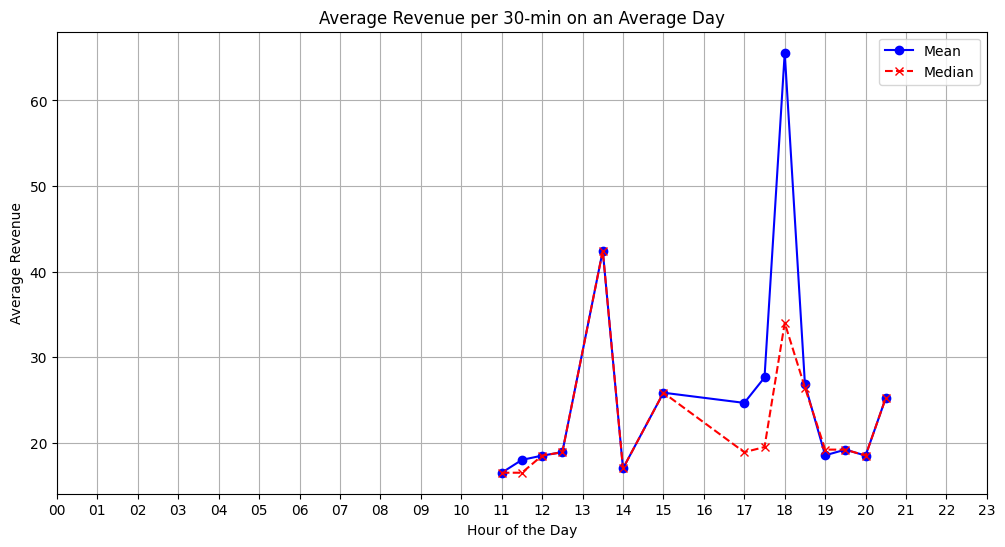

     order_id  item_quantity  item_fractional_price  \
285       256              1                   1920   
289       260              1                   1700   
293       262              1                   1650   
294       264              1                   1650   
296       266              1                   1850   

     modifier_fractional_price  modifier_quantity order_placed_timestamp  \
285                          0                  0    2023-07-22 11:14:33   
289                          0                  0    2023-07-22 13:34:42   
293                          0                  0    2023-07-22 15:42:05   
294                          0                  0    2023-07-22 16:28:35   
296                          0                  0    2023-07-22 18:19:40   

     order_value  revenue  
285         19.2     19.2  
289         17.0     17.0  
293         16.5     16.5  
294         16.5     16.5  
296         18.5     37.0  


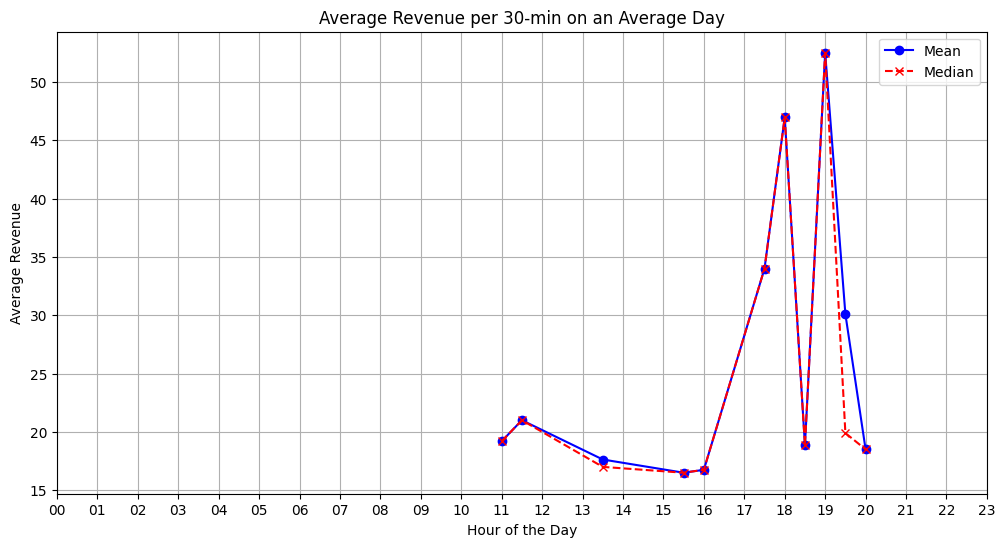

In [57]:
def calculate_revenue(df: pd.DataFrame,order_timestamp_column:str):
    # Calculate the actual average revenue for each interval on an average day
    df = df[
        [
            "order_id",
            "item_quantity",
            "item_fractional_price",
            "modifier_fractional_price",
            "modifier_quantity",
            order_timestamp_column,
        ]
    ].copy()
    df.fillna(0, inplace=True)
    df["order_value"] = (
        (df["item_fractional_price"] * df["item_quantity"])
        + (df["modifier_fractional_price"] * df["modifier_quantity"])
    ) / 100
    # print(df.groupby("order_id").head())
    df["revenue"] = df.groupby("order_id")["order_value"].transform("sum")
    return df


def plot_average_revenue_per_interval(df, interval):
    order_timestamp = "order_placed_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    df = calculate_revenue(df,order_timestamp)
    # print(df["revenue"])
    print(df.head())
    # Create a new column for the interval index
    df["interval_index"] = (
        df[order_timestamp].dt.hour * 60 + df[order_timestamp].dt.minute
    ) // interval

    # Calculate the mean and median revenue for each interval
    mean_revenue = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["revenue"]
        .sum()
        .groupby("interval_index")
        .mean()
    )

    median_revenue = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["revenue"]
        .sum()
        .groupby("interval_index")
        .median()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plot both mean and median revenue per interval
    plt.figure(figsize=(12, 6))
    plt.plot(
        mean_revenue,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Mean",
    )
    plt.plot(
        median_revenue,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Average Revenue")
    plt.title(f"Average Revenue per {interval}-min on an Average Day")
    plt.xticks(range(0, num_intervals, int(60 / interval)), x_labels)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_average_revenue_per_interval(pre_dp_df_weekdays, interval)
plot_average_revenue_per_interval(pre_dp_df_weekends, interval)

plot_average_revenue_per_interval(post_dp_df_weekdays, interval)
plot_average_revenue_per_interval(post_dp_df_weekends, interval)

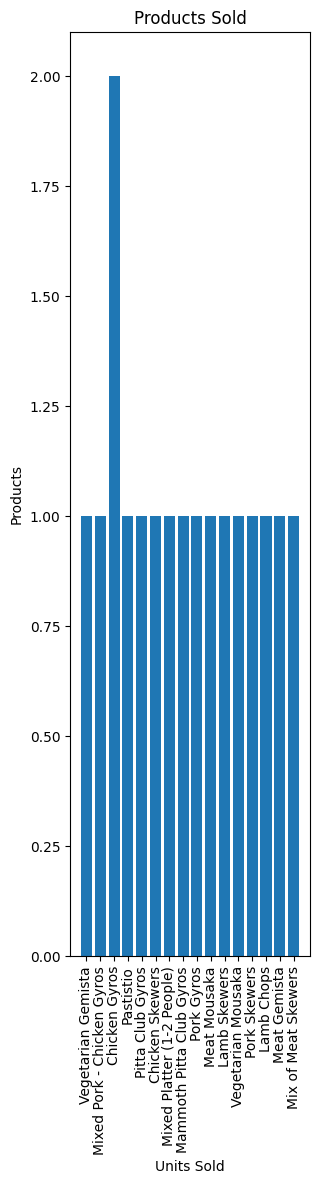

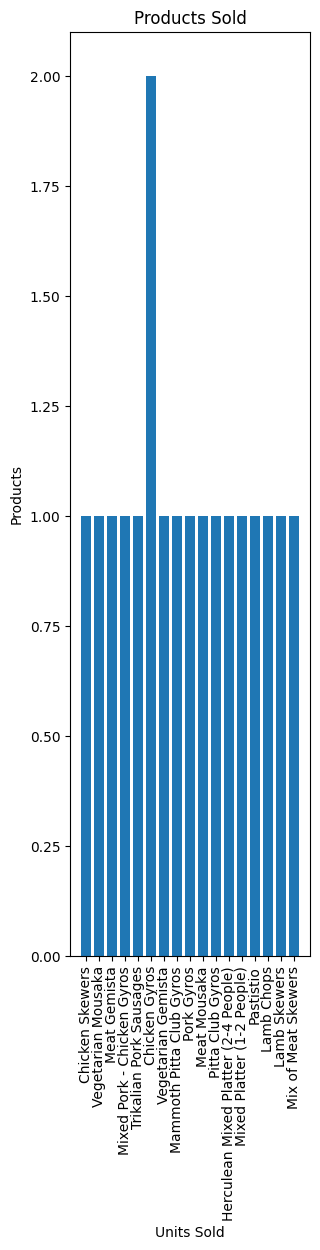

In [58]:
def plot_items_sold(df):
    df = df[["order_id","item_name","item_quantity"]].copy()

    plt.figure(figsize=(6, 12))
    plt.bar(df["item_name"], df["item_quantity"])
    plt.ylabel('Products')
    plt.xlabel('Units Sold')
    plt.title('Products Sold')
    plt.xticks(rotation=90)
    plt.subplots_adjust(left=0.5)  # Adjust the value as needed
    plt.show()

plot_items_sold(pre_dp_df)
plot_items_sold(post_dp_df)

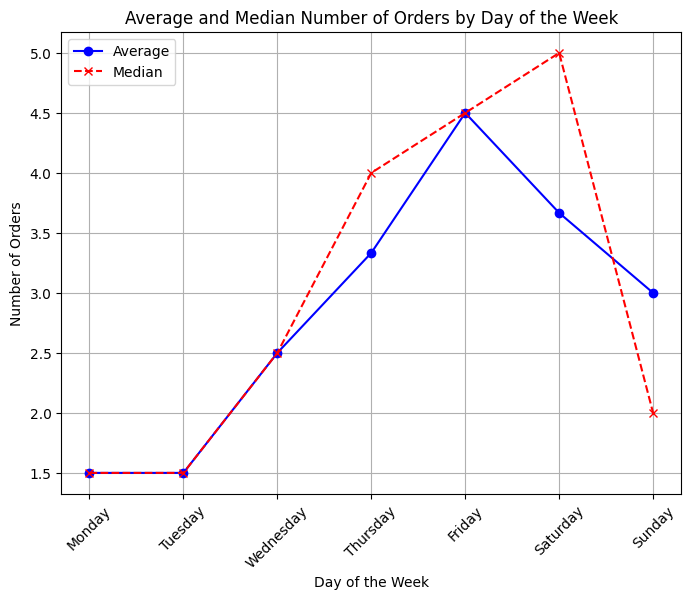

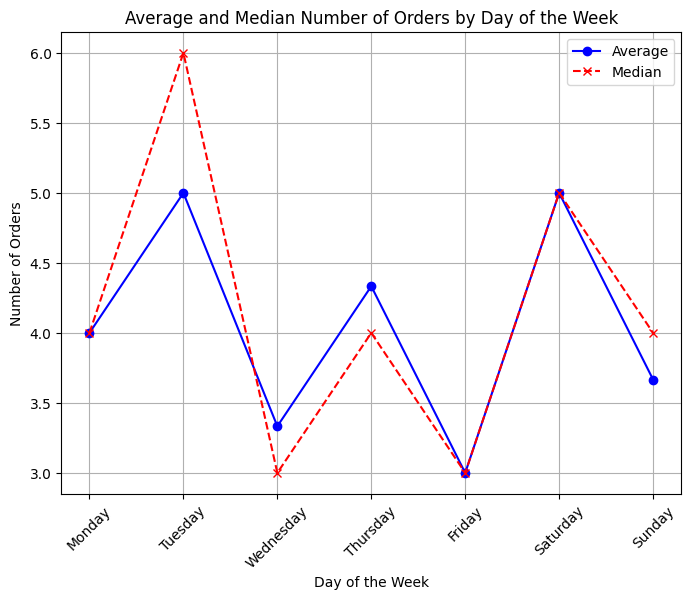

In [59]:
def plot_average_orders_by_day_of_week(df):
    order_timestamp = "order_placed_timestamp"
    # Extract the day of the week from the order_datetime column
    df["day_of_week"] = df[order_timestamp].dt.day_name()

    # Group by day of the week and calculate both average and median number of orders
    average_orders = (
        df.groupby(["day_of_week", df[order_timestamp].dt.date])
        .size()
        .groupby("day_of_week")
        .mean()
    )
    median_orders = (
        df.groupby(["day_of_week", df[order_timestamp].dt.date])
        .size()
        .groupby("day_of_week")
        .median()
    )

    # Define the order of days for proper sorting in the plot
    weekdays = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]

    # Reindex the DataFrames to include all weekdays in the desired order
    average_orders = average_orders.reindex(weekdays)
    median_orders = median_orders.reindex(weekdays)

    # Generate the x-axis labels for the day of the week
    x_labels = weekdays

    # Plotting both average and median number of orders by day of the week as a line plot
    plt.figure(figsize=(8, 6))
    plt.plot(
        average_orders,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Average",
    )
    plt.plot(
        median_orders,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Day of the Week")
    plt.ylabel("Number of Orders")
    plt.title("Average and Median Number of Orders by Day of the Week")
    plt.xticks(range(len(weekdays)), x_labels, rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_average_orders_by_day_of_week(pre_dp_df)
plot_average_orders_by_day_of_week(post_dp_df)

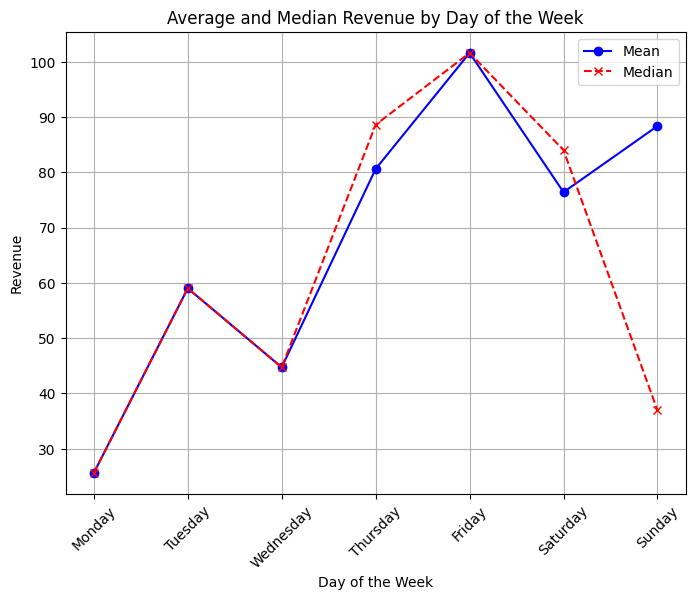

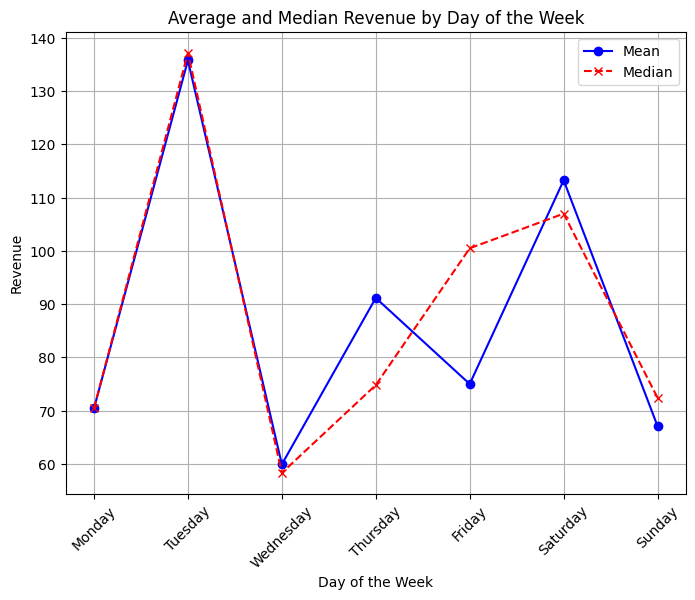

In [60]:
def plot_average_revenue_by_day_of_week(df):
    order_timestamp = "order_placed_timestamp"
    # Calculate the average revenue by day of the week
    df = calculate_revenue(df,order_timestamp)

    # Extract the day of the week from the order_datetime column
    df["day_of_week"] = df[order_timestamp].dt.day_name()

    average_revenue_by_day = (
        df.groupby(["day_of_week", df[order_timestamp].dt.date])["revenue"]
        .sum()
        .groupby("day_of_week")
        .mean()
    )
    median_revenue_by_day = (
        df.groupby(["day_of_week", df[order_timestamp].dt.date])["revenue"]
        .sum()
        .groupby("day_of_week")
        .median()
    )

    # Define the order of days for proper sorting in the plot
    weekdays = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]

    # Reindex the DataFrames to include all weekdays in the desired order
    average_revenue_by_day = average_revenue_by_day.reindex(weekdays)
    median_revenue_by_day = median_revenue_by_day.reindex(weekdays)

    # Generate the x-axis labels for the day of the week
    x_labels = weekdays

    # Plotting both mean and median revenue by day of the week as a line plot
    plt.figure(figsize=(8, 6))
    plt.plot(
        average_revenue_by_day,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Mean",
    )
    plt.plot(
        median_revenue_by_day,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Day of the Week")
    plt.ylabel("Revenue")
    plt.title("Average and Median Revenue by Day of the Week")
    plt.xticks(range(len(weekdays)), x_labels, rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_average_revenue_by_day_of_week(pre_dp_df)
plot_average_revenue_by_day_of_week(post_dp_df)

/tmp/ipykernel_32503/2273651215.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32503/2273651215.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



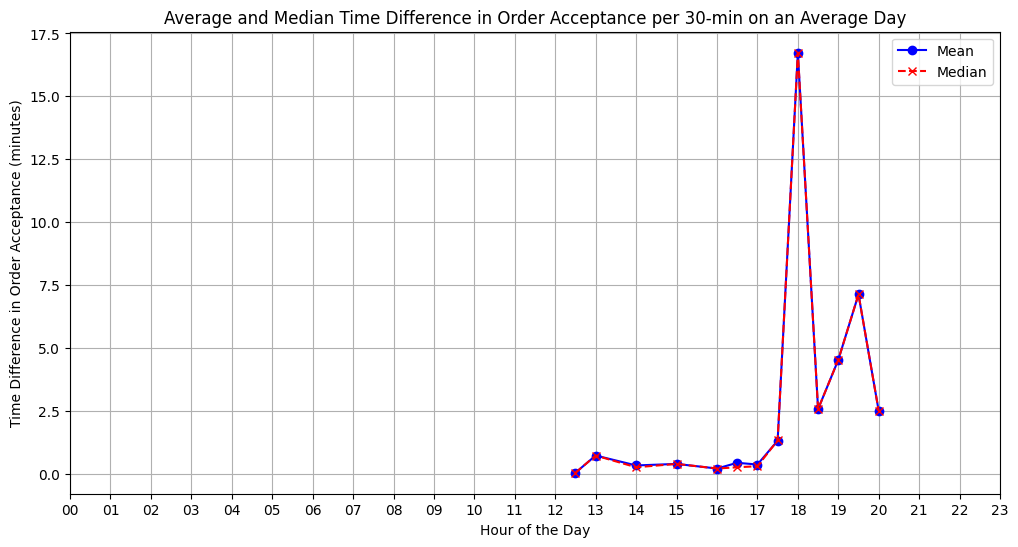

/tmp/ipykernel_32503/2273651215.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32503/2273651215.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



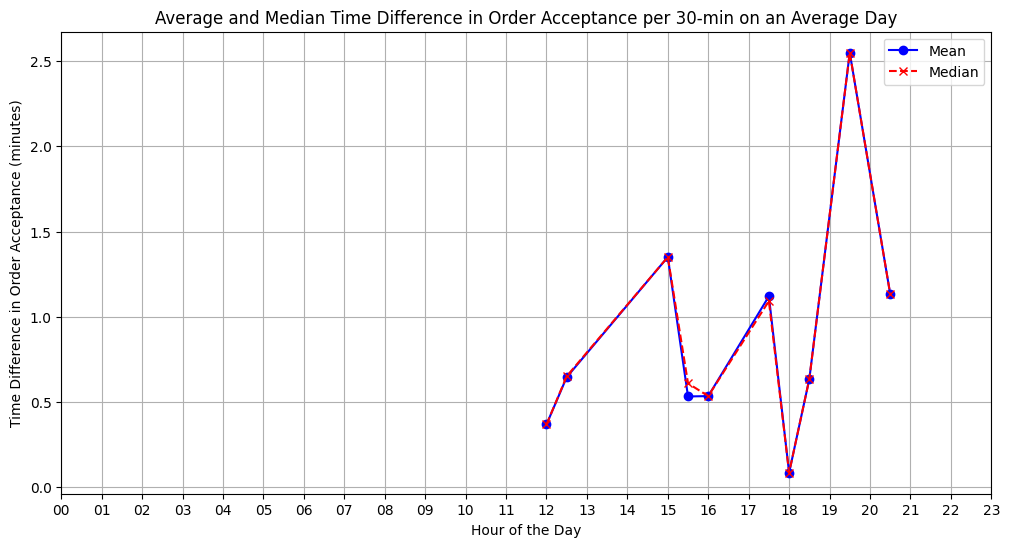

/tmp/ipykernel_32503/2273651215.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32503/2273651215.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



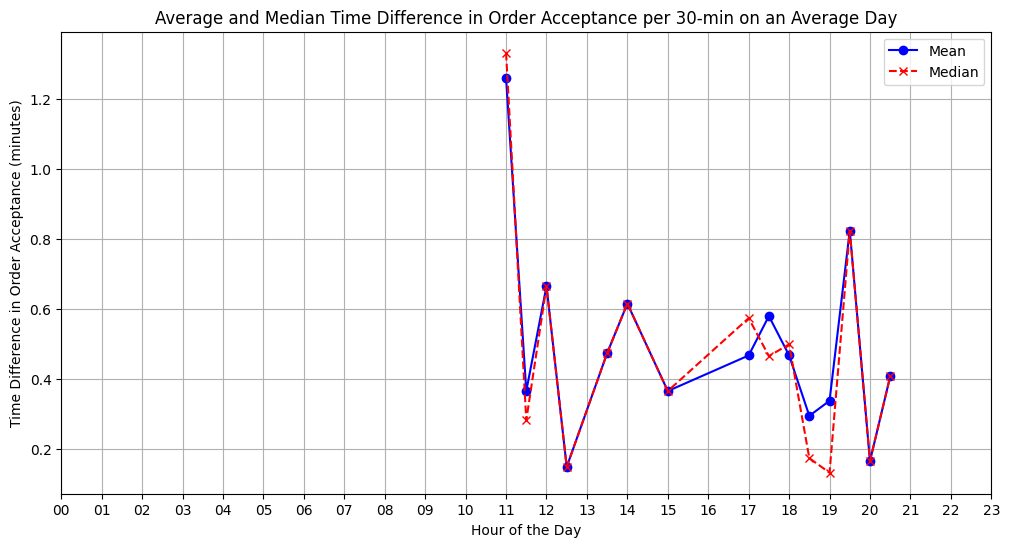

/tmp/ipykernel_32503/2273651215.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32503/2273651215.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



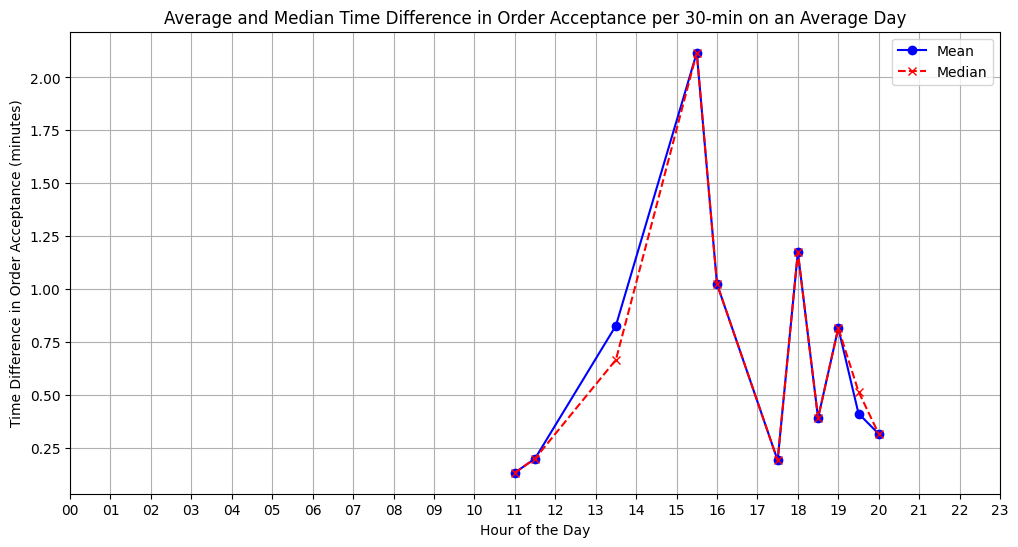

In [61]:
def time_difference_in_order_acceptance_per_interval(df, interval):
    order_timestamp = "order_placed_timestamp"
    accepted_timestamp = "order_updated_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    # Create a new column for the interval index
    df["interval_index"] = (
        df[order_timestamp].dt.hour * 60 + df[order_timestamp].dt.minute
    ) // interval

    # Calculate the time difference between order placement and acceptance
    df["time_difference"] = (
        df[accepted_timestamp] - df[order_timestamp]
    ).dt.total_seconds() / 60

    # Calculate both mean and median time difference for each interval on an average day
    mean_time_difference = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["time_difference"]
        .mean()
        .groupby("interval_index")
        .mean()
    )

    median_time_difference = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["time_difference"]
        .median()
        .groupby("interval_index")
        .median()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plotting both mean and median time difference in order acceptance per interval
    plt.figure(figsize=(12, 6))
    plt.plot(
        mean_time_difference,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Mean",
    )
    plt.plot(
        median_time_difference,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Time Difference in Order Acceptance (minutes)")
    plt.title(
        f"Average and Median Time Difference in Order Acceptance per {interval}-min on an Average Day"
    )
    plt.xticks(range(0, num_intervals, 60 // interval), x_labels)
    plt.grid(True)
    plt.legend()
    plt.show()

time_difference_in_order_acceptance_per_interval(pre_dp_df_weekdays, interval)
time_difference_in_order_acceptance_per_interval(pre_dp_df_weekends, interval)

time_difference_in_order_acceptance_per_interval(post_dp_df_weekdays, interval)
time_difference_in_order_acceptance_per_interval(post_dp_df_weekends, interval)

/tmp/ipykernel_32503/193725362.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32503/193725362.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



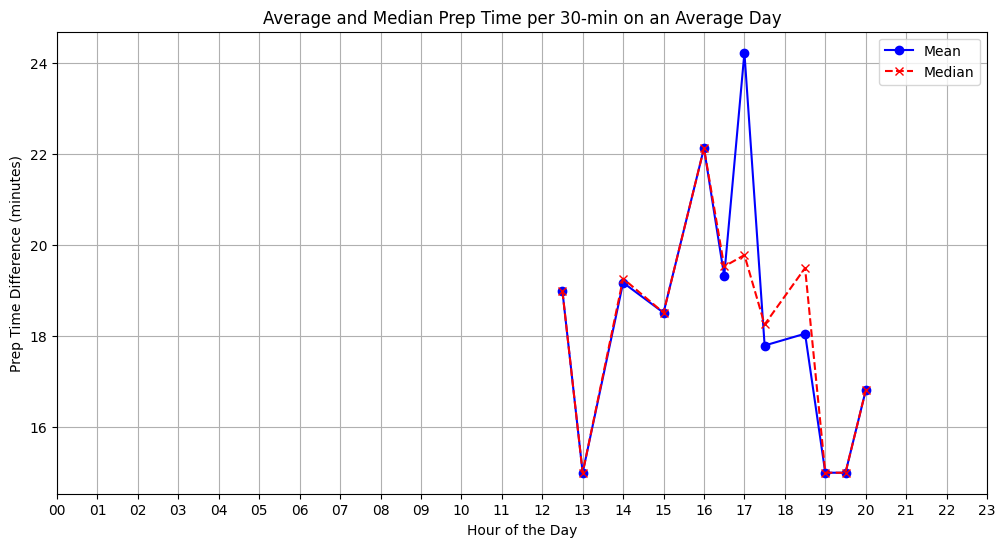

/tmp/ipykernel_32503/193725362.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32503/193725362.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



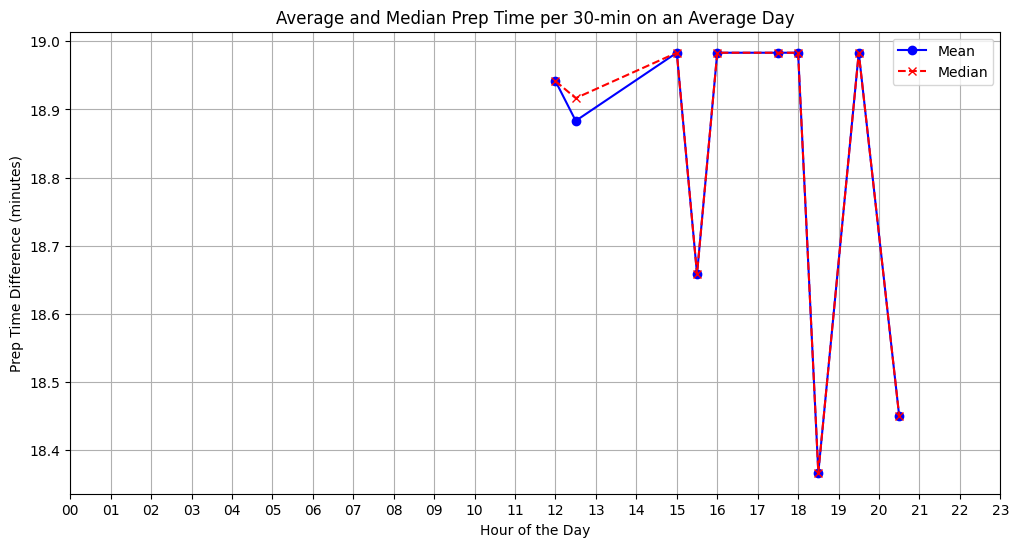

/tmp/ipykernel_32503/193725362.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32503/193725362.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



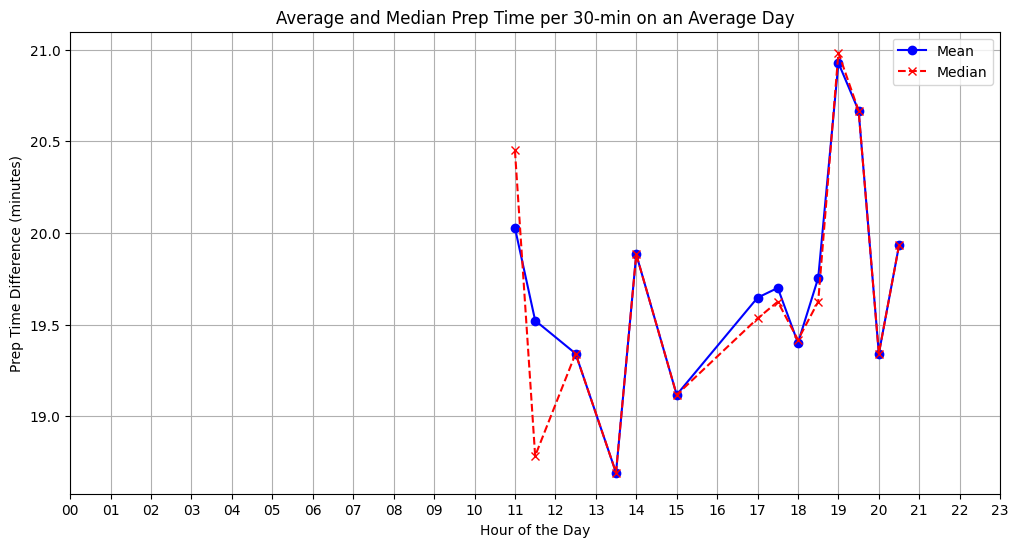

/tmp/ipykernel_32503/193725362.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32503/193725362.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



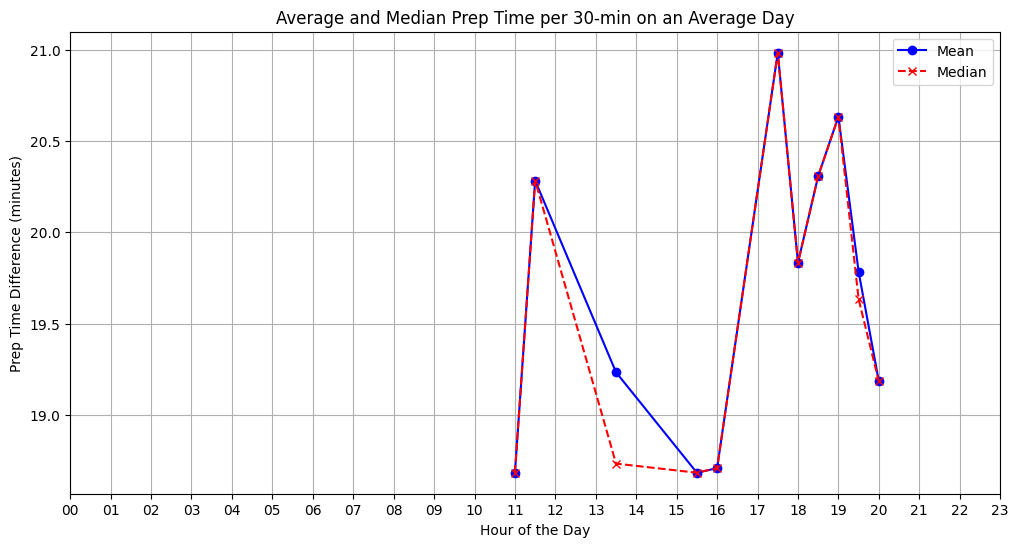

In [62]:
def prep_time_per_interval(df, interval):
    """Use https://api-docs.deliveroo.com/v2.0/docs/order-integration to understand why these timestamps are used"""
    start_prep_time = "order_start_prepping_at_timestamp"
    end_prep_time = "order_prepare_for_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    # Create a new column for the interval index
    df["interval_index"] = (
        df[start_prep_time].dt.hour * 60 + df[start_prep_time].dt.minute
    ) // interval

    # Calculate the time difference between order placement and acceptance
    df["time_difference"] = (
        df[end_prep_time] - df[start_prep_time]
    ).dt.total_seconds() / 60

    # Calculate both mean and median time difference for each interval on an average day
    mean_time_difference = (
        df.groupby(["interval_index", df[start_prep_time].dt.date])["time_difference"]
        .mean()
        .groupby("interval_index")
        .mean()
    )

    median_time_difference = (
        df.groupby(["interval_index", df[start_prep_time].dt.date])["time_difference"]
        .median()
        .groupby("interval_index")
        .median()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plotting both mean and median prep time per interval
    plt.figure(figsize=(12, 6))
    plt.plot(
        mean_time_difference,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Mean",
    )
    plt.plot(
        median_time_difference,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Prep Time Difference (minutes)")
    plt.title(f"Average and Median Prep Time per {interval}-min on an Average Day")
    plt.xticks(range(0, num_intervals, 60 // interval), x_labels)
    plt.grid(True)
    plt.legend()
    plt.show()

prep_time_per_interval(pre_dp_df_weekdays, interval)
prep_time_per_interval(pre_dp_df_weekends, interval)

prep_time_per_interval(post_dp_df_weekdays, interval)
prep_time_per_interval(post_dp_df_weekends, interval)

Manage outliers

In [63]:
revenue_df = calculate_revenue(pre_dp_df,"order_placed_timestamp")
largest_series = revenue_df["revenue"].nlargest(5).reset_index(drop=True)
print(largest_series)
difference_amount = largest_series[1]-largest_series[2]
print(difference_amount)
revenue_df[revenue_df["revenue"] == largest_series[1]] #the outlier was on a wednesday at 5.26pm

0    52.2
1    52.2
2    52.2
3    50.5
4    50.5
Name: revenue, dtype: float64
0.0


,order_id,item_quantity,item_fractional_price,modifier_fractional_price,modifier_quantity,order_placed_timestamp,order_value,revenue
60,56,1,1770,0,0,2023-07-02 15:43:11,17.7,52.2
62,56,1,1800,0,0,2023-07-02 15:43:11,18.0,52.2
65,56,1,1650,0,0,2023-07-02 15:43:11,16.5,52.2


In [64]:
import pandas as pd


def calculate_revenue_by_day_period(
    df, order_timestamp_column="order_placed_timestamp", time_intervals=None
):

    if time_intervals is None:
        raise ValueError("Please provide time intervals.")

    df["order_value"] = (
        (df["item_fractional_price"] * df["item_quantity"])
        + (df["modifier_fractional_price"] * df["modifier_quantity"])
    ) / 100
    time_intervals = [pd.to_datetime(str(time)).time() for time in time_intervals]

    interval_labels = [
        f"{time_intervals[i]} to {time_intervals[i+1]}"
        for i in range(len(time_intervals) - 1)
    ]

    df["interval_label"] = pd.cut(
        df[order_timestamp_column].dt.time, bins=time_intervals, labels=interval_labels
    )

    return df.groupby("interval_label", observed=True)["order_value"].sum()

time_intervals = ["00:00", "14:00", "18:45", "23:59:59"]
pre_dp_df_weekday_revenue = calculate_revenue_by_day_period(
    pre_dp_df_weekdays, time_intervals=time_intervals
)

pre_dp_df_weekend_revenue = calculate_revenue_by_day_period(
    pre_dp_df_weekends, time_intervals=time_intervals
)
post_dp_df_weekday_revenue = calculate_revenue_by_day_period(
    post_dp_df_weekdays, time_intervals=time_intervals
)
post_dp_df_weekend_revenue = calculate_revenue_by_day_period(
    post_dp_df_weekends, time_intervals=time_intervals
)

print(pre_dp_df_weekday_revenue, pre_dp_df_weekday_revenue.sum())
print(pre_dp_df_weekend_revenue, pre_dp_df_weekend_revenue.sum())
print(post_dp_df_weekday_revenue, post_dp_df_weekday_revenue.sum())
print(post_dp_df_weekend_revenue, post_dp_df_weekend_revenue.sum())

interval_label
00:00:00 to 14:00:00     34.2
14:00:00 to 18:45:00    448.2
18:45:00 to 23:59:59    103.2
Name: order_value, dtype: float64 585.6
interval_label
00:00:00 to 14:00:00     84.0
14:00:00 to 18:45:00    231.5
18:45:00 to 23:59:59     37.9
Name: order_value, dtype: float64 353.4
interval_label
00:00:00 to 14:00:00    191.6
14:00:00 to 18:45:00    715.1
18:45:00 to 23:59:59    213.5
Name: order_value, dtype: float64 1120.2
interval_label
00:00:00 to 14:00:00     93.1
14:00:00 to 18:45:00    140.9
18:45:00 to 23:59:59    235.0
Name: order_value, dtype: float64 469.0


/tmp/ipykernel_32503/2927867988.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32503/2927867988.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32503/2927867988.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

In [65]:
import pandas as pd


def calculate_profit_by_day_period(
    df, order_timestamp_column="order_placed_timestamp", time_intervals=None
):

    if time_intervals is None:
        raise ValueError("Please provide time intervals.")

    df.loc[:, "order_value"] = (
        (df["item_fractional_price"] * df["item_quantity"])
        + (df["modifier_fractional_price"] * df["modifier_quantity"])
    ) / 100

    df.loc[:, "profit"] = df["order_value"] - (df["item_fractional_cost"] / 100)

    time_intervals = [pd.to_datetime(str(time)).time() for time in time_intervals]

    interval_labels = [
        f"{time_intervals[i]} to {time_intervals[i+1]}"
        for i in range(len(time_intervals) - 1)
    ]

    df.loc[:, "interval_label"] = pd.cut(
        df[order_timestamp_column].dt.time, bins=time_intervals, labels=interval_labels
    )

    return df.groupby("interval_label", observed=True)["profit"].sum()


time_intervals = ["00:00", "14:00", "18:45", "23:59:59"]
pre_dp_df_weekday_profit = calculate_profit_by_day_period(
    pre_dp_df_weekdays, time_intervals=time_intervals
)

pre_dp_df_weekend_profit = calculate_profit_by_day_period(
    pre_dp_df_weekends, time_intervals=time_intervals
)
post_dp_df_weekday_profit = calculate_profit_by_day_period(
    post_dp_df_weekdays, time_intervals=time_intervals
)
post_dp_df_weekend_profit = calculate_profit_by_day_period(
    post_dp_df_weekends, time_intervals=time_intervals
)

# remove outlier
pre_dp_df_weekday_profit.loc["14:00:00 to 18:45:00"] -= difference_amount

print(pre_dp_df_weekday_profit, pre_dp_df_weekday_profit.sum())
print(pre_dp_df_weekend_profit, pre_dp_df_weekend_profit.sum())
print(post_dp_df_weekday_profit, post_dp_df_weekday_profit.sum())
print(post_dp_df_weekend_profit, post_dp_df_weekend_profit.sum())

/tmp/ipykernel_32503/4288003078.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32503/4288003078.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_32503/4288003078.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

interval_label
00:00:00 to 14:00:00     21.7
14:00:00 to 18:45:00    291.7
18:45:00 to 23:59:59     69.2
Name: profit, dtype: float64 382.59999999999997
interval_label
00:00:00 to 14:00:00     53.0
14:00:00 to 18:45:00    146.0
18:45:00 to 23:59:59     21.4
Name: profit, dtype: float64 220.4
interval_label
00:00:00 to 14:00:00    118.1
14:00:00 to 18:45:00    462.1
18:45:00 to 23:59:59    135.0
Name: profit, dtype: float64 715.1999999999999
interval_label
00:00:00 to 14:00:00     58.1
14:00:00 to 18:45:00     89.9
18:45:00 to 23:59:59    148.0
Name: profit, dtype: float64 296.0


In [66]:
def generate_menu_matrix(df: pd.DataFrame):
    # Calculate profit for each item

    #!NOTE: THIS IS SIMPLIFIED BECAUSE THERE ARE NO MODIFIERS
    df["item_revenue"] = (df["item_quantity"] * df["item_fractional_price"])/100
    df["item_cost"] = (df["item_quantity"] * df["item_fractional_cost"])/100

    # Aggregate data to calculate popularity and profitability(profit-margin) for each item
    item_popularity = df.groupby("item_name")["item_quantity"].sum()
    item_revenue = df.groupby("item_name")["item_revenue"].sum()
    item_cost = df.groupby("item_name")["item_cost"].sum()
    item_profitability = (item_revenue - item_cost) / item_revenue

    # Calculate thresholds for popularity and profitability
    popularity_threshold = item_popularity.quantile(0.5)  # Adjust as needed
    profitability_threshold = item_profitability.quantile(0.5)  # Adjust as needed

    # Categorize items
    def categorize_item(row):
        item_name = row["item_name"]
        popularity = item_popularity.get(item_name, 0)
        profitability = item_profitability.get(item_name, 0)

        if popularity >= popularity_threshold and profitability >= profitability_threshold:
            return "Star"
        elif popularity < popularity_threshold and profitability >= profitability_threshold:
            return "Puzzle"
        elif popularity >= popularity_threshold and profitability < profitability_threshold:
            return "Cash Cow"
        else:
            return "Dud"

    df["category"] = df.apply(categorize_item, axis=1)
    # Adding popularity and profitability to the dataframe
    df["item_popularity"] = df["item_name"].map(item_popularity)
    df["item_profitability"] = df["item_name"].map(item_profitability)

    return df

all_items_pre_df_menu_matrix = generate_menu_matrix(all_items_pre_dp_df)
all_items_post_df_menu_matrix = generate_menu_matrix(all_items_post_dp_df)
print(pd.crosstab(index=all_items_pre_df_menu_matrix["category"], columns="count"))
print(pd.crosstab(index=all_items_post_df_menu_matrix["category"], columns="count"))

col_0     count
category       
Cash Cow     37
Puzzle        3
Star         74
col_0     count
category       
Cash Cow     50
Dud           4
Puzzle       11
Star         71


In [67]:
import plotly.express as px

def plot_menu_matrix(df):
    fig = px.scatter(
        df,
        x="item_profitability",
        y="item_popularity",
        color="category",
        hover_name="item_name",
        title="Menu Matrix",
        labels={"item_profitability": "Profitability", "item_popularity": "Popularity"},
        color_discrete_map={
            "Star": "blue",
            "Puzzle": "green",
            "Cash Cow": "orange",
            "Dud": "red",
        },
        opacity=0.7,
    )

    # Add text annotations next to each point
    for i, row in df.iterrows():
        fig.add_annotation(
            x=row["item_profitability"],
            y=row["item_popularity"],
            text=row["item_name"],
            showarrow=False,
            font=dict(size=8),
            xshift=5,
            yshift=10,
        )

    fig.show()

plot_menu_matrix(all_items_pre_df_menu_matrix)
plot_menu_matrix(all_items_post_df_menu_matrix)

checkout any major events 
look at seasionality of the month